### Model Inference Code and demos ###

In [1]:
import sys
sys.path.append('.')

import time
import io
import torch
from PIL import Image, ImageDraw, ImageFont
from network.backbone_utils import swin_fpn_backbone
from netcmd.cmd import CascadeMiningDet
from torchvision import transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def creat_model():
    print("using {} device.".format(device))
    CLASSES = {"__background__", "CTC", "CTC-like"}
    backbone = swin_fpn_backbone()
    model = CascadeMiningDet(backbone, num_classes=len(CLASSES))
    model.to(device)

    pth_path = '/home/stat-zx/model_service/parameters/swins_cmd.pth'   # model weights path
    statdic = torch.load(pth_path)
    model.load_state_dict(statdic)
    model.eval()

    return model

In [4]:
def predict(image_path):
    # creat model
    model = creat_model()

    # load image
    original_img = Image.open(image_path).convert('RGB')
    
    # from pil image to tensor, do not normalize image
    transform=transforms.Compose([transforms.ToTensor()])
    img = transform(original_img)
    
    # expand batch dimension
    img = torch.unsqueeze(img, dim=0)  # type: ignore
    outputs = model(img.to(device))
    
    if len(outputs[-1]["boxes"]) == 0:
        print('no CTCs/CTC-like cells detected')
    else:
        new_output_index = torch.where(outputs[-1]["scores"] > 0.5)
        new_boxes = outputs[-1]["boxes"][new_output_index]
        new_scores = outputs[-1]["scores"][new_output_index]
        new_labels = outputs[-1]["labels"][new_output_index]

        coords = [] 
        for i in range(len(new_boxes)):
            new_box = new_boxes[i].tolist()
            coords.append([new_box[0], new_box[1],
                            new_box[2], new_box[3]])
        coords_score = new_scores.tolist()
        coords_labels = new_labels.tolist()
        if len(coords) == 0:
            print('no CTCs/CTC-like cells detected')
            
        draw = ImageDraw.Draw(original_img)

        # draw boxes and scores
        tl = round(0.002*(original_img.size[0]+original_img.size[1]) + 1)
        font = ImageFont.truetype(font="/usr/share/fonts/dejavu/DejaVuSans.ttf",size=5*tl)
        for box,score,label in zip(coords,coords_score,coords_labels):
            if label == 1:
                draw.rectangle(box, outline=(255,0,0), width=tl)
                draw.text((box[0] + tl,box[1] + tl), f'{score:.2f}',(255,0,0),font)
            else:
                draw.ellipse(box,outline=(255,0,0),width=tl)
                draw.text((box[0] + tl,box[1] + tl), f'{score:.2f}',(255,0,0),font)

    return original_img

In [5]:
img = '/home/stat-zx/8.CTC_data/JPEGImages/04_Ma_img_006.jpg' # image path
pred = predict(img) # predict

using cuda:0 device.


/home/stat-zx/anaconda3/envs/tia/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


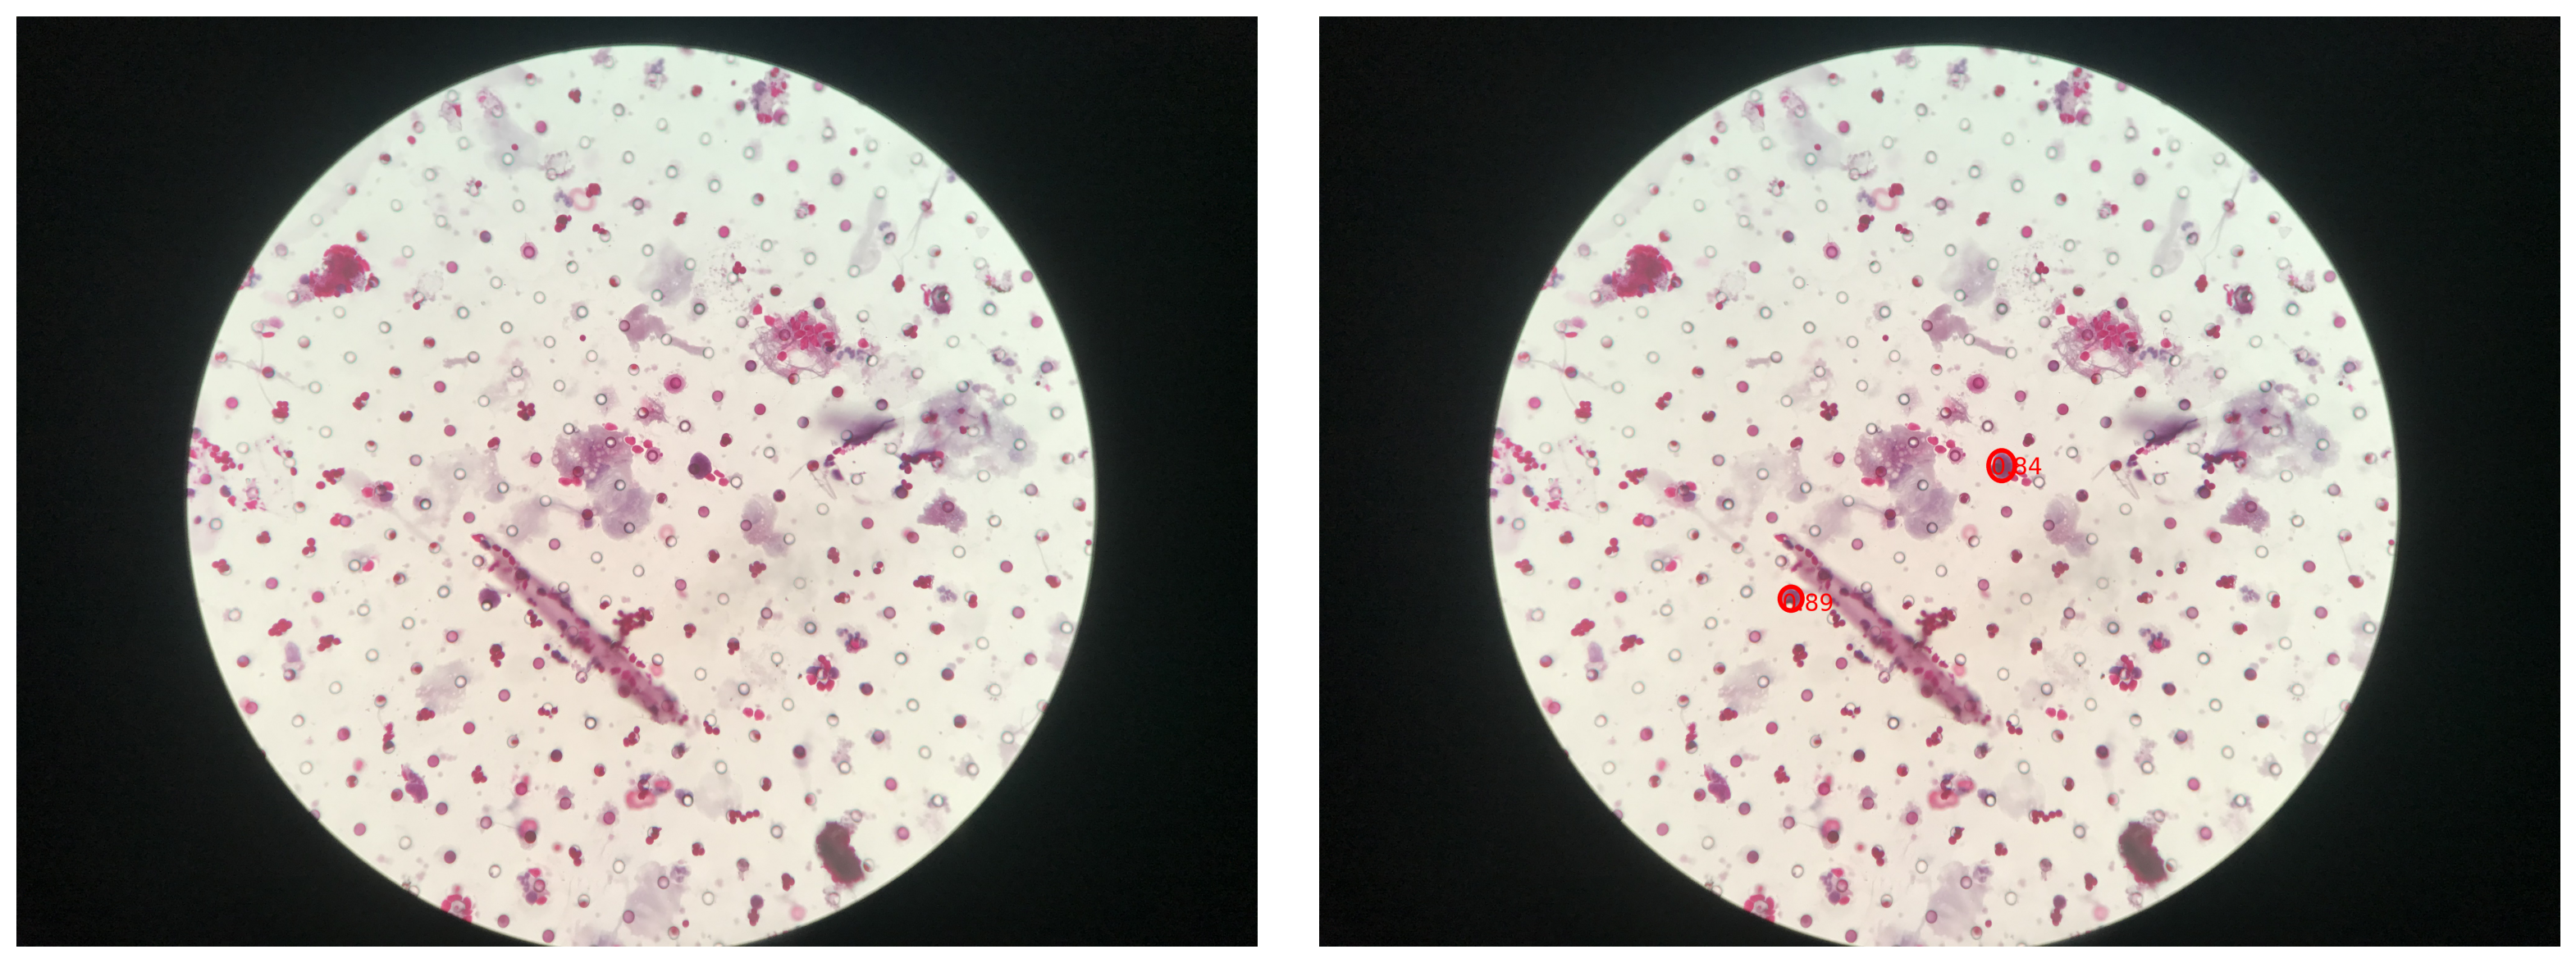

In [11]:
# show origin image and prediction
import matplotlib.pyplot as plt

origin = Image.open(img)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10), dpi=200)

ax1.imshow(origin)
ax2.imshow(pred)

ax1.axis('off')
ax2.axis('off')

plt.subplots_adjust(wspace=0.05) 
plt.show()